# U3 L1 P4 - Model Comparison

### Emile Badran

Find a data set and build a KNN Regression and an OLS regression. Compare the two. How similar are they? Do they miss in different ways?

Write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model.

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.options.display.float_format = '{:,.5f}'.format

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import neighbors
from sklearn.model_selection import cross_val_score

import statsmodels.formula.api as smf

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


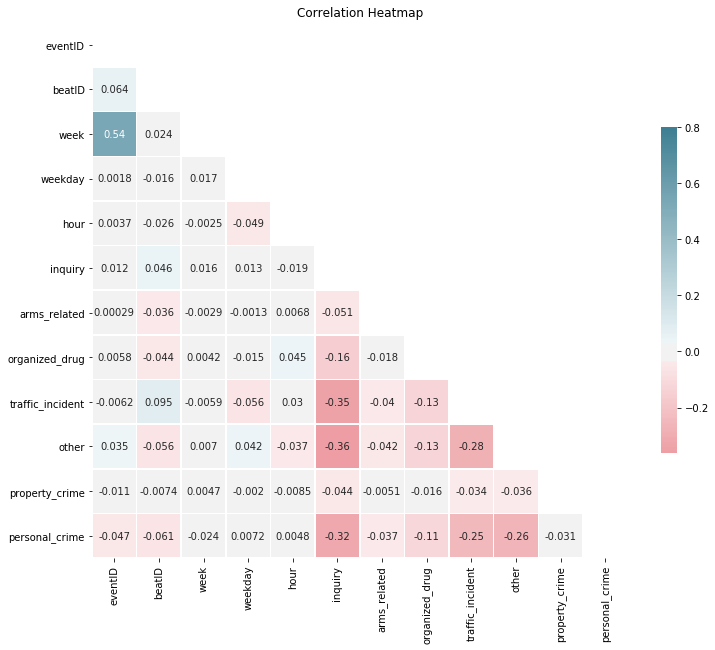

In [2]:
df = pd.read_csv('pmsc_features.csv')
df.date = pd.to_datetime(df.date)
df.set_index('date',inplace=True)
df = df.sort_index()

# Create a correlation heatmap
# Generate a mask for the upper triangle
mask = np.zeros_like(df.corr(),dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df.corr(),
            mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.title('Correlation Heatmap')
plt.show()

In [3]:
# Drop unnecessary columns, or uncorrelated columns:
df = df.drop(columns=['eventID','event_type','event_cat',
                      'hour','weekday','week','property_crime'])

#### Crime type descriptions:
- violent_crime - Homicide, Rape and Sexual Assault, Robbery, Assault, Stalking/intimidation
- property_crime - Burglary, Larceny/theft, Motor vehicle theft, Purse snatching, and Pocket picking
- organized_drug - Organized or drug-related crime, including possesion, use, sales, and trafficking
- traffic_incident - Traffic-related incidents
- inquiry - Stops-and-frisks, arrest warrants, investigations, and other policing activities
- other - Misdemeanors and other crimes
- arms_related - Arms-related offenses

## Predict personal crime with linear regression:

In [4]:
# Fit the StatsModels linear regression:

linear_formula = 'personal_crime ~ inquiry+organized_drug+traffic_incident+other+arms_related'

# Fit the model to 60% of the size of the data:
lm = smf.ols(formula=linear_formula, data=df.iloc[:int(len(df)*.6),:]).fit()

# Cross-validated prediction:
end = int(len(df)/10)

for i in range(10):   

    # Predict with the test sample WITHOUT THE TARGET COLUMN:
    y_pred = lm.predict(exog=df.iloc[:end,:-1])
    target = df.personal_crime[:end]
    
    # Convert predictions to 0 or 1 based on a threshold:
    y_pred = y_pred.apply(lambda x: 1 if x>0.5 else 0)

    # Since the prediction is binary, it is useless to visualize residual values 
    # with a scatterplot. Instead, print p-values, r-squared and confusion matrix:
    print('\nROUND',i, '- sample size:', len(df.iloc[:end,:-1]),'/ 42460')
    print(lm.params)
    print('\np-values:')
    print(lm.pvalues)
    print('\nr-squared:')
    print(lm.rsquared)
    print('\nconfusion mat:')
    print(confusion_matrix(target, y_pred))
    print('\n--------------------')
    
    # Increase sample size by 10%:
    end = end+(int(len(df)/10))


ROUND 0 - sample size: 4246 / 42460
Intercept           0.97967
inquiry            -0.97967
organized_drug     -0.97967
traffic_incident   -0.97967
other              -0.97967
arms_related       -0.97967
dtype: float64

p-values:
Intercept          0.00000
inquiry            0.00000
organized_drug     0.00000
traffic_incident   0.00000
other              0.00000
arms_related       0.00000
dtype: float64

r-squared:
0.974865840559

confusion mat:
[[3352   16]
 [   0  878]]

--------------------

ROUND 1 - sample size: 8492 / 42460
Intercept           0.97967
inquiry            -0.97967
organized_drug     -0.97967
traffic_incident   -0.97967
other              -0.97967
arms_related       -0.97967
dtype: float64

p-values:
Intercept          0.00000
inquiry            0.00000
organized_drug     0.00000
traffic_incident   0.00000
other              0.00000
arms_related       0.00000
dtype: float64

r-squared:
0.974865840559

confusion mat:
[[6727   44]
 [   0 1721]]

--------------------


## Predict personal crime with KNN:

In [5]:
# Test the model with different holdout groups with sklearn:
df_train, df_test = train_test_split(df, test_size=0.4, random_state=20)

# Build our model.
knn = neighbors.KNeighborsClassifier(n_neighbors=10)

# Fit the model with TRAIN data:
estimator = knn.fit(df_train.iloc[:,:-1], df_train.personal_crime)

# Test the model with TEST data excluding personal crime:
prediction = knn.predict(df_test.iloc[:,:-1])

df_test['prediction'] = prediction

print('clockwise - TN, FP, TP, FN')
confusion_matrix(df_test.personal_crime, df_test.prediction)

clockwise - TN, FP, TP, FN


array([[13646,   184],
       [   56,  3102]])

In [6]:
# Cross-validate the Knn regression:
scores = cross_val_score(estimator, df_train.iloc[:,:-1], df_train.personal_crime, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f std)" % (scores.mean(), scores.std() * 2))

[ 0.97999215  0.97919937  0.98626374  0.98704867  0.98783359  0.98233909
  0.98508634  0.98390895  0.98587127  0.98547311]
Accuracy: 0.98 (+/- 0.01 std)


### Analysis of both models:
Both models seem to work well, although I would choose to use the linear regression since it is slightly more accurate. That said, the KNN classification returns categorical boolean values, which is an advantage over linear regression, which returns continuous values. In our case, the values predicted by the linear regression were 0.9797 and -0.00000. If the results were less precise (e.g., 0.6 and 0.4), I would opt for KNN.